# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

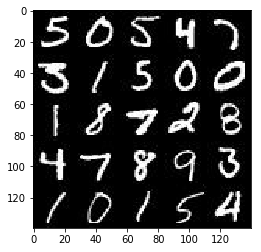

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

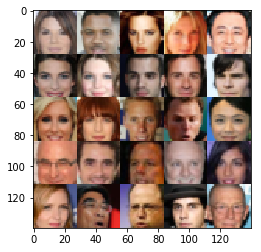

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(dtype=tf.float32, 
                                       shape = [None,image_width, image_height, image_channels], name='Input_image')
    z_data = tf.placeholder(dtype=tf.float32 , shape = [None,z_dim], name='z_input')
    LR = tf.placeholder(dtype = tf.float32, shape=[], name='learning_rate')

    return real_input_images, z_data, LR


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Hardcode a value for alpha
    alpha = 0.01 # For Leaky RELU
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # The Output of first convolution layer is 16 x 16 x 32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batch2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * batch2, batch2)
        # The Output of second convolution layer is 8 x 8 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batch3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * batch3, batch3)
        # The Output of third convolution layer is 4 x 4 x 256
        
        flat = tf.reshape(relu3, (-1,4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [43]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
#   We hardcode a value for alpha
    alpha = 0.2   # For Leaky RELU
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z,7*7*512)
        # Reshape it to start the convolutions stack
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1 , x1)
        # The output of first Convolution connected layer is now 7 x 7 x 512
        
        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2 , x2)
        # The output of second fully connected layer is now 7 x 7 x 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2 , padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3 , x3)
        # The output of third fully connected layer is now 14 x 14 x 128
        
        # Output layer is 28 x 28 x out_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    real_input_images, z_data, LR = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input_images, z_data,
                                              data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every=10
    show_every=100
    figsize=(5,5)
    losses, samples = [], []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, LR: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, LR: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({real_input_images: batch_images, z_data: batch_z})
                    train_loss_g = g_loss.eval({z_data: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, z_data, data_shape[3], data_image_mode)
        
        # Generate Discriminator vs Generator Loss Graph After completion of Epochs 
        # X axis value = steps / 10 since losses stored only after every 10 batches 
        fig, ax = pyplot.subplots()
        losses = np.array(losses)
        pyplot.plot(losses.T[0], label='Discriminator')
        pyplot.plot(losses.T[1], label='Generator')
        pyplot.title("Training Losses")
        pyplot.legend()
    
    return losses     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.9953... Generator Loss: 1.6256
Epoch 1/2... Batch 20... Discriminator Loss: 1.5616... Generator Loss: 1.1122
Epoch 1/2... Batch 30... Discriminator Loss: 1.4015... Generator Loss: 1.5629
Epoch 1/2... Batch 40... Discriminator Loss: 1.0389... Generator Loss: 2.1467
Epoch 1/2... Batch 50... Discriminator Loss: 1.1645... Generator Loss: 1.9588
Epoch 1/2... Batch 60... Discriminator Loss: 1.4375... Generator Loss: 1.2939
Epoch 1/2... Batch 70... Discriminator Loss: 1.4552... Generator Loss: 1.5292
Epoch 1/2... Batch 80... Discriminator Loss: 1.4597... Generator Loss: 1.4412
Epoch 1/2... Batch 90... Discriminator Loss: 1.3583... Generator Loss: 1.4872
Epoch 1/2... Batch 100... Discriminator Loss: 1.2440... Generator Loss: 1.4727


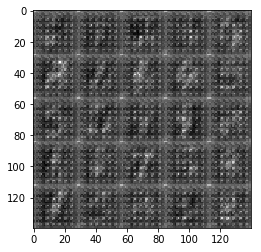

Epoch 1/2... Batch 110... Discriminator Loss: 1.2399... Generator Loss: 1.5593
Epoch 1/2... Batch 120... Discriminator Loss: 1.2747... Generator Loss: 1.7359
Epoch 1/2... Batch 130... Discriminator Loss: 1.1098... Generator Loss: 1.3761
Epoch 1/2... Batch 140... Discriminator Loss: 1.0600... Generator Loss: 1.4223
Epoch 1/2... Batch 150... Discriminator Loss: 1.0807... Generator Loss: 1.4614
Epoch 1/2... Batch 160... Discriminator Loss: 1.0870... Generator Loss: 1.3524
Epoch 1/2... Batch 170... Discriminator Loss: 1.0188... Generator Loss: 1.4851
Epoch 1/2... Batch 180... Discriminator Loss: 0.9734... Generator Loss: 1.5834
Epoch 1/2... Batch 190... Discriminator Loss: 0.9762... Generator Loss: 1.3817
Epoch 1/2... Batch 200... Discriminator Loss: 1.1050... Generator Loss: 1.7293


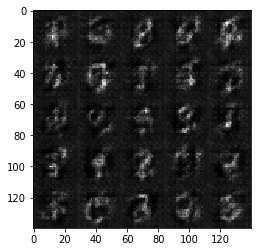

Epoch 1/2... Batch 210... Discriminator Loss: 1.0371... Generator Loss: 1.5978
Epoch 1/2... Batch 220... Discriminator Loss: 1.0026... Generator Loss: 1.6895
Epoch 1/2... Batch 230... Discriminator Loss: 1.0164... Generator Loss: 1.8498
Epoch 1/2... Batch 240... Discriminator Loss: 0.9282... Generator Loss: 1.5058
Epoch 1/2... Batch 250... Discriminator Loss: 0.9567... Generator Loss: 1.5832
Epoch 1/2... Batch 260... Discriminator Loss: 0.9048... Generator Loss: 1.5747
Epoch 1/2... Batch 270... Discriminator Loss: 0.9137... Generator Loss: 1.6027
Epoch 1/2... Batch 280... Discriminator Loss: 0.8598... Generator Loss: 1.4294
Epoch 1/2... Batch 290... Discriminator Loss: 0.8292... Generator Loss: 1.5119
Epoch 1/2... Batch 300... Discriminator Loss: 1.1062... Generator Loss: 1.8289


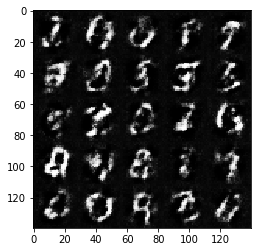

Epoch 1/2... Batch 310... Discriminator Loss: 0.8765... Generator Loss: 1.6266
Epoch 1/2... Batch 320... Discriminator Loss: 0.8281... Generator Loss: 1.5792
Epoch 1/2... Batch 330... Discriminator Loss: 0.8854... Generator Loss: 1.3560
Epoch 1/2... Batch 340... Discriminator Loss: 0.9170... Generator Loss: 1.4625
Epoch 1/2... Batch 350... Discriminator Loss: 1.1125... Generator Loss: 2.0893
Epoch 1/2... Batch 360... Discriminator Loss: 0.7960... Generator Loss: 1.4190
Epoch 1/2... Batch 370... Discriminator Loss: 0.9718... Generator Loss: 1.8118
Epoch 1/2... Batch 380... Discriminator Loss: 0.9681... Generator Loss: 1.3714
Epoch 1/2... Batch 390... Discriminator Loss: 0.9584... Generator Loss: 0.7651
Epoch 1/2... Batch 400... Discriminator Loss: 1.4762... Generator Loss: 0.3113


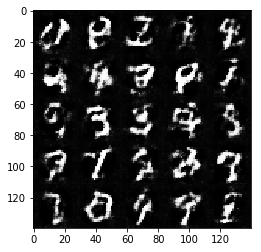

Epoch 1/2... Batch 410... Discriminator Loss: 1.1082... Generator Loss: 0.5265
Epoch 1/2... Batch 420... Discriminator Loss: 1.3336... Generator Loss: 0.3955
Epoch 1/2... Batch 430... Discriminator Loss: 1.1616... Generator Loss: 0.4950
Epoch 1/2... Batch 440... Discriminator Loss: 1.4002... Generator Loss: 0.3528
Epoch 1/2... Batch 450... Discriminator Loss: 1.1882... Generator Loss: 0.4840
Epoch 1/2... Batch 460... Discriminator Loss: 1.1013... Generator Loss: 0.5324
Epoch 2/2... Batch 470... Discriminator Loss: 1.3543... Generator Loss: 0.3809
Epoch 2/2... Batch 480... Discriminator Loss: 1.1933... Generator Loss: 0.4837
Epoch 2/2... Batch 490... Discriminator Loss: 1.3196... Generator Loss: 0.3921
Epoch 2/2... Batch 500... Discriminator Loss: 1.3345... Generator Loss: 0.4020


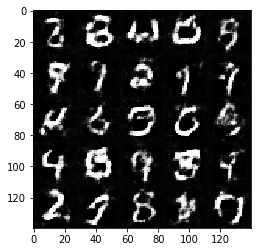

Epoch 2/2... Batch 510... Discriminator Loss: 1.2533... Generator Loss: 0.4382
Epoch 2/2... Batch 520... Discriminator Loss: 1.3625... Generator Loss: 0.3816
Epoch 2/2... Batch 530... Discriminator Loss: 1.1802... Generator Loss: 0.4996
Epoch 2/2... Batch 540... Discriminator Loss: 1.3699... Generator Loss: 0.3655
Epoch 2/2... Batch 550... Discriminator Loss: 1.1097... Generator Loss: 0.5277
Epoch 2/2... Batch 560... Discriminator Loss: 1.3343... Generator Loss: 0.3916
Epoch 2/2... Batch 570... Discriminator Loss: 1.1391... Generator Loss: 0.5462
Epoch 2/2... Batch 580... Discriminator Loss: 1.1888... Generator Loss: 0.4841
Epoch 2/2... Batch 590... Discriminator Loss: 1.3610... Generator Loss: 0.3694
Epoch 2/2... Batch 600... Discriminator Loss: 1.1096... Generator Loss: 0.5466


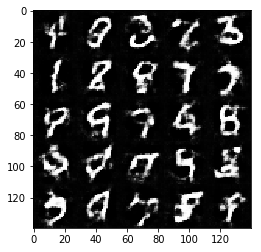

Epoch 2/2... Batch 610... Discriminator Loss: 1.3592... Generator Loss: 0.3938
Epoch 2/2... Batch 620... Discriminator Loss: 1.2032... Generator Loss: 0.4747
Epoch 2/2... Batch 630... Discriminator Loss: 1.2265... Generator Loss: 0.4616
Epoch 2/2... Batch 640... Discriminator Loss: 1.4031... Generator Loss: 0.3510
Epoch 2/2... Batch 650... Discriminator Loss: 1.3792... Generator Loss: 0.3760
Epoch 2/2... Batch 660... Discriminator Loss: 1.2105... Generator Loss: 0.4656
Epoch 2/2... Batch 670... Discriminator Loss: 1.1659... Generator Loss: 0.5090
Epoch 2/2... Batch 680... Discriminator Loss: 1.4406... Generator Loss: 0.3384
Epoch 2/2... Batch 690... Discriminator Loss: 1.2117... Generator Loss: 0.4887
Epoch 2/2... Batch 700... Discriminator Loss: 1.2175... Generator Loss: 0.4665


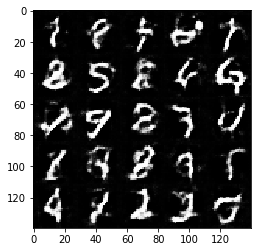

Epoch 2/2... Batch 710... Discriminator Loss: 1.4755... Generator Loss: 0.3195
Epoch 2/2... Batch 720... Discriminator Loss: 1.3744... Generator Loss: 0.3912
Epoch 2/2... Batch 730... Discriminator Loss: 1.2720... Generator Loss: 0.4334
Epoch 2/2... Batch 740... Discriminator Loss: 1.3729... Generator Loss: 0.3675
Epoch 2/2... Batch 750... Discriminator Loss: 1.3219... Generator Loss: 0.4148
Epoch 2/2... Batch 760... Discriminator Loss: 1.3972... Generator Loss: 0.3718
Epoch 2/2... Batch 770... Discriminator Loss: 1.3766... Generator Loss: 0.3763
Epoch 2/2... Batch 780... Discriminator Loss: 1.1671... Generator Loss: 0.5382
Epoch 2/2... Batch 790... Discriminator Loss: 0.9638... Generator Loss: 0.9535
Epoch 2/2... Batch 800... Discriminator Loss: 1.1267... Generator Loss: 1.4505


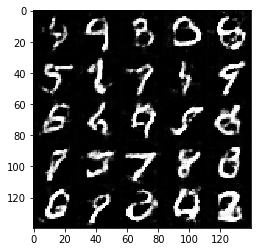

Epoch 2/2... Batch 810... Discriminator Loss: 0.9380... Generator Loss: 1.2273
Epoch 2/2... Batch 820... Discriminator Loss: 1.0530... Generator Loss: 1.4394
Epoch 2/2... Batch 830... Discriminator Loss: 1.0375... Generator Loss: 0.6702
Epoch 2/2... Batch 840... Discriminator Loss: 1.2845... Generator Loss: 0.4276
Epoch 2/2... Batch 850... Discriminator Loss: 1.2194... Generator Loss: 0.4541
Epoch 2/2... Batch 860... Discriminator Loss: 1.2983... Generator Loss: 0.4475
Epoch 2/2... Batch 870... Discriminator Loss: 1.2142... Generator Loss: 0.4646
Epoch 2/2... Batch 880... Discriminator Loss: 1.1412... Generator Loss: 0.5272
Epoch 2/2... Batch 890... Discriminator Loss: 1.2901... Generator Loss: 0.4363
Epoch 2/2... Batch 900... Discriminator Loss: 1.2323... Generator Loss: 0.4436


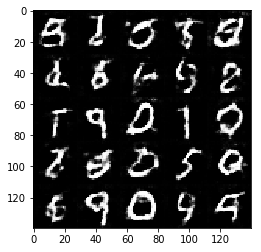

Epoch 2/2... Batch 910... Discriminator Loss: 2.9311... Generator Loss: 0.0687
Epoch 2/2... Batch 920... Discriminator Loss: 0.9855... Generator Loss: 0.7182
Epoch 2/2... Batch 930... Discriminator Loss: 0.9058... Generator Loss: 0.8625


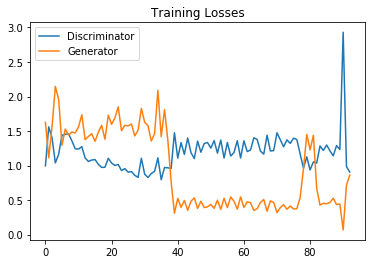

In [40]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.0005


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.5495... Generator Loss: 0.4991
Epoch 1/1... Batch 20... Discriminator Loss: 1.0373... Generator Loss: 1.5567
Epoch 1/1... Batch 30... Discriminator Loss: 0.7567... Generator Loss: 2.4241
Epoch 1/1... Batch 40... Discriminator Loss: 0.5928... Generator Loss: 1.6632
Epoch 1/1... Batch 50... Discriminator Loss: 2.0010... Generator Loss: 5.6481
Epoch 1/1... Batch 60... Discriminator Loss: 1.1380... Generator Loss: 1.6819
Epoch 1/1... Batch 70... Discriminator Loss: 1.4212... Generator Loss: 1.3818
Epoch 1/1... Batch 80... Discriminator Loss: 1.3489... Generator Loss: 1.5275
Epoch 1/1... Batch 90... Discriminator Loss: 1.1084... Generator Loss: 1.5049
Epoch 1/1... Batch 100... Discriminator Loss: 1.3290... Generator Loss: 0.9443


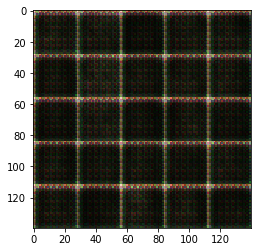

Epoch 1/1... Batch 110... Discriminator Loss: 1.5559... Generator Loss: 1.5800
Epoch 1/1... Batch 120... Discriminator Loss: 1.3101... Generator Loss: 1.3536
Epoch 1/1... Batch 130... Discriminator Loss: 1.5292... Generator Loss: 1.3293
Epoch 1/1... Batch 140... Discriminator Loss: 1.3681... Generator Loss: 0.9398
Epoch 1/1... Batch 150... Discriminator Loss: 1.3345... Generator Loss: 1.4357
Epoch 1/1... Batch 160... Discriminator Loss: 1.4044... Generator Loss: 1.1034
Epoch 1/1... Batch 170... Discriminator Loss: 1.2969... Generator Loss: 1.3333
Epoch 1/1... Batch 180... Discriminator Loss: 1.3231... Generator Loss: 1.3131
Epoch 1/1... Batch 190... Discriminator Loss: 1.4230... Generator Loss: 1.2904
Epoch 1/1... Batch 200... Discriminator Loss: 1.2167... Generator Loss: 1.2731


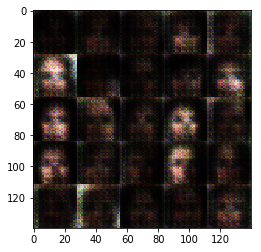

Epoch 1/1... Batch 210... Discriminator Loss: 1.2898... Generator Loss: 1.4485
Epoch 1/1... Batch 220... Discriminator Loss: 1.3281... Generator Loss: 1.1686
Epoch 1/1... Batch 230... Discriminator Loss: 1.1825... Generator Loss: 1.3684
Epoch 1/1... Batch 240... Discriminator Loss: 0.8921... Generator Loss: 1.0542
Epoch 1/1... Batch 250... Discriminator Loss: 1.3963... Generator Loss: 1.3392
Epoch 1/1... Batch 260... Discriminator Loss: 1.1413... Generator Loss: 1.6967
Epoch 1/1... Batch 270... Discriminator Loss: 1.2442... Generator Loss: 1.4302
Epoch 1/1... Batch 280... Discriminator Loss: 1.3260... Generator Loss: 1.4347
Epoch 1/1... Batch 290... Discriminator Loss: 1.1574... Generator Loss: 1.9920
Epoch 1/1... Batch 300... Discriminator Loss: 1.0022... Generator Loss: 1.6181


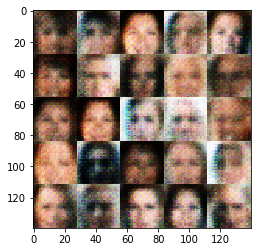

Epoch 1/1... Batch 310... Discriminator Loss: 1.1727... Generator Loss: 1.6565
Epoch 1/1... Batch 320... Discriminator Loss: 1.2344... Generator Loss: 1.5999
Epoch 1/1... Batch 330... Discriminator Loss: 0.8802... Generator Loss: 1.4230
Epoch 1/1... Batch 340... Discriminator Loss: 1.0817... Generator Loss: 1.4416
Epoch 1/1... Batch 350... Discriminator Loss: 1.1726... Generator Loss: 1.2399
Epoch 1/1... Batch 360... Discriminator Loss: 1.1554... Generator Loss: 1.4225
Epoch 1/1... Batch 370... Discriminator Loss: 1.1562... Generator Loss: 1.4149
Epoch 1/1... Batch 380... Discriminator Loss: 1.0223... Generator Loss: 1.5182
Epoch 1/1... Batch 390... Discriminator Loss: 1.1014... Generator Loss: 1.2923
Epoch 1/1... Batch 400... Discriminator Loss: 1.1976... Generator Loss: 0.9602


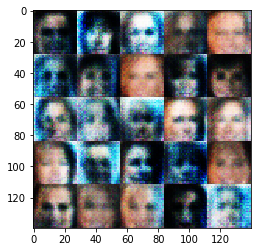

Epoch 1/1... Batch 410... Discriminator Loss: 1.2948... Generator Loss: 1.6907
Epoch 1/1... Batch 420... Discriminator Loss: 1.4467... Generator Loss: 1.1075
Epoch 1/1... Batch 430... Discriminator Loss: 1.2881... Generator Loss: 0.9867
Epoch 1/1... Batch 440... Discriminator Loss: 1.2011... Generator Loss: 0.8941
Epoch 1/1... Batch 450... Discriminator Loss: 1.1560... Generator Loss: 1.6592
Epoch 1/1... Batch 460... Discriminator Loss: 1.3700... Generator Loss: 1.1418
Epoch 1/1... Batch 470... Discriminator Loss: 1.1340... Generator Loss: 1.1258
Epoch 1/1... Batch 480... Discriminator Loss: 1.4112... Generator Loss: 1.4603
Epoch 1/1... Batch 490... Discriminator Loss: 1.0594... Generator Loss: 1.2939
Epoch 1/1... Batch 500... Discriminator Loss: 1.0717... Generator Loss: 1.6369


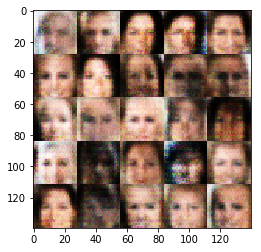

Epoch 1/1... Batch 510... Discriminator Loss: 1.4416... Generator Loss: 1.1632
Epoch 1/1... Batch 520... Discriminator Loss: 1.1206... Generator Loss: 1.1392
Epoch 1/1... Batch 530... Discriminator Loss: 1.3264... Generator Loss: 1.0423
Epoch 1/1... Batch 540... Discriminator Loss: 1.1998... Generator Loss: 1.2495
Epoch 1/1... Batch 550... Discriminator Loss: 1.3240... Generator Loss: 1.2833
Epoch 1/1... Batch 560... Discriminator Loss: 1.2804... Generator Loss: 0.5671
Epoch 1/1... Batch 570... Discriminator Loss: 1.5234... Generator Loss: 0.3854
Epoch 1/1... Batch 580... Discriminator Loss: 1.3482... Generator Loss: 0.4596
Epoch 1/1... Batch 590... Discriminator Loss: 1.5783... Generator Loss: 0.3324
Epoch 1/1... Batch 600... Discriminator Loss: 1.5762... Generator Loss: 0.3273


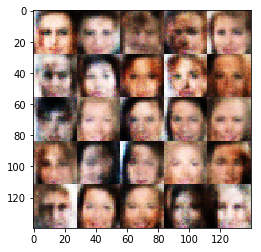

Epoch 1/1... Batch 610... Discriminator Loss: 1.4140... Generator Loss: 0.4462
Epoch 1/1... Batch 620... Discriminator Loss: 1.2491... Generator Loss: 0.6012
Epoch 1/1... Batch 630... Discriminator Loss: 1.6242... Generator Loss: 0.3155
Epoch 1/1... Batch 640... Discriminator Loss: 1.3206... Generator Loss: 0.4838
Epoch 1/1... Batch 650... Discriminator Loss: 1.6025... Generator Loss: 0.3105
Epoch 1/1... Batch 660... Discriminator Loss: 1.6580... Generator Loss: 0.2840
Epoch 1/1... Batch 670... Discriminator Loss: 1.5219... Generator Loss: 0.3591
Epoch 1/1... Batch 680... Discriminator Loss: 1.4778... Generator Loss: 0.3567
Epoch 1/1... Batch 690... Discriminator Loss: 1.4593... Generator Loss: 0.3891
Epoch 1/1... Batch 700... Discriminator Loss: 1.5066... Generator Loss: 0.3558


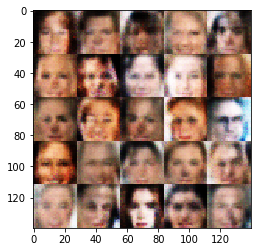

Epoch 1/1... Batch 710... Discriminator Loss: 1.4338... Generator Loss: 0.3852
Epoch 1/1... Batch 720... Discriminator Loss: 1.2338... Generator Loss: 0.5434
Epoch 1/1... Batch 730... Discriminator Loss: 1.4365... Generator Loss: 0.3865
Epoch 1/1... Batch 740... Discriminator Loss: 1.2979... Generator Loss: 0.5075
Epoch 1/1... Batch 750... Discriminator Loss: 1.5278... Generator Loss: 0.3592
Epoch 1/1... Batch 760... Discriminator Loss: 1.2681... Generator Loss: 0.5465
Epoch 1/1... Batch 770... Discriminator Loss: 1.4021... Generator Loss: 0.4432
Epoch 1/1... Batch 780... Discriminator Loss: 1.2487... Generator Loss: 0.5775
Epoch 1/1... Batch 790... Discriminator Loss: 1.3843... Generator Loss: 0.4451
Epoch 1/1... Batch 800... Discriminator Loss: 1.1016... Generator Loss: 0.6801


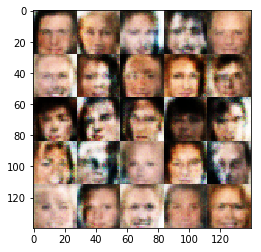

Epoch 1/1... Batch 810... Discriminator Loss: 1.5203... Generator Loss: 1.3492
Epoch 1/1... Batch 820... Discriminator Loss: 1.3805... Generator Loss: 1.4506
Epoch 1/1... Batch 830... Discriminator Loss: 1.0797... Generator Loss: 1.1276
Epoch 1/1... Batch 840... Discriminator Loss: 1.1705... Generator Loss: 1.4197
Epoch 1/1... Batch 850... Discriminator Loss: 0.9746... Generator Loss: 1.2863
Epoch 1/1... Batch 860... Discriminator Loss: 1.4159... Generator Loss: 1.1144
Epoch 1/1... Batch 870... Discriminator Loss: 1.0773... Generator Loss: 1.4098
Epoch 1/1... Batch 880... Discriminator Loss: 1.2941... Generator Loss: 1.1557
Epoch 1/1... Batch 890... Discriminator Loss: 1.0958... Generator Loss: 1.3656
Epoch 1/1... Batch 900... Discriminator Loss: 1.0739... Generator Loss: 1.2969


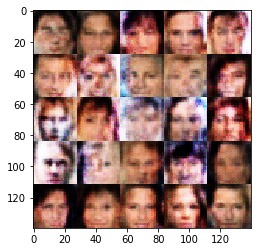

Epoch 1/1... Batch 910... Discriminator Loss: 1.2902... Generator Loss: 1.0274
Epoch 1/1... Batch 920... Discriminator Loss: 1.0900... Generator Loss: 0.6937
Epoch 1/1... Batch 930... Discriminator Loss: 1.6899... Generator Loss: 0.2880
Epoch 1/1... Batch 940... Discriminator Loss: 1.6801... Generator Loss: 0.2710
Epoch 1/1... Batch 950... Discriminator Loss: 1.7287... Generator Loss: 0.2583
Epoch 1/1... Batch 960... Discriminator Loss: 1.4671... Generator Loss: 0.3685
Epoch 1/1... Batch 970... Discriminator Loss: 1.3174... Generator Loss: 0.4752
Epoch 1/1... Batch 980... Discriminator Loss: 1.5786... Generator Loss: 0.3576
Epoch 1/1... Batch 990... Discriminator Loss: 1.5536... Generator Loss: 0.3433
Epoch 1/1... Batch 1000... Discriminator Loss: 1.1109... Generator Loss: 0.6101


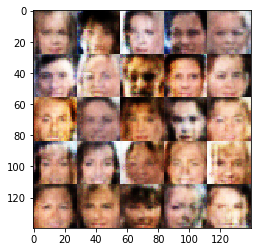

Epoch 1/1... Batch 1010... Discriminator Loss: 1.1730... Generator Loss: 0.5697
Epoch 1/1... Batch 1020... Discriminator Loss: 1.3913... Generator Loss: 0.4297
Epoch 1/1... Batch 1030... Discriminator Loss: 1.4210... Generator Loss: 0.3839
Epoch 1/1... Batch 1040... Discriminator Loss: 1.0776... Generator Loss: 0.6383
Epoch 1/1... Batch 1050... Discriminator Loss: 1.3321... Generator Loss: 0.4433
Epoch 1/1... Batch 1060... Discriminator Loss: 1.4360... Generator Loss: 0.3999
Epoch 1/1... Batch 1070... Discriminator Loss: 1.3097... Generator Loss: 0.5706
Epoch 1/1... Batch 1080... Discriminator Loss: 1.6365... Generator Loss: 0.2974
Epoch 1/1... Batch 1090... Discriminator Loss: 1.3637... Generator Loss: 0.4208
Epoch 1/1... Batch 1100... Discriminator Loss: 1.6824... Generator Loss: 0.2719


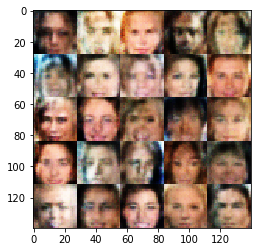

Epoch 1/1... Batch 1110... Discriminator Loss: 1.2839... Generator Loss: 0.4859
Epoch 1/1... Batch 1120... Discriminator Loss: 1.3769... Generator Loss: 0.4568
Epoch 1/1... Batch 1130... Discriminator Loss: 1.5314... Generator Loss: 0.3412
Epoch 1/1... Batch 1140... Discriminator Loss: 1.3605... Generator Loss: 0.4197
Epoch 1/1... Batch 1150... Discriminator Loss: 1.1366... Generator Loss: 0.5745
Epoch 1/1... Batch 1160... Discriminator Loss: 1.9737... Generator Loss: 0.1923
Epoch 1/1... Batch 1170... Discriminator Loss: 1.4295... Generator Loss: 0.4104
Epoch 1/1... Batch 1180... Discriminator Loss: 1.2680... Generator Loss: 0.5074
Epoch 1/1... Batch 1190... Discriminator Loss: 1.5531... Generator Loss: 0.3358
Epoch 1/1... Batch 1200... Discriminator Loss: 1.4791... Generator Loss: 0.3607


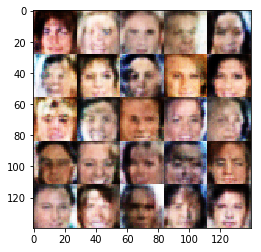

Epoch 1/1... Batch 1210... Discriminator Loss: 1.2547... Generator Loss: 0.4891
Epoch 1/1... Batch 1220... Discriminator Loss: 1.4365... Generator Loss: 0.4061
Epoch 1/1... Batch 1230... Discriminator Loss: 1.2020... Generator Loss: 0.6811
Epoch 1/1... Batch 1240... Discriminator Loss: 1.0187... Generator Loss: 1.7158
Epoch 1/1... Batch 1250... Discriminator Loss: 0.8435... Generator Loss: 0.9318
Epoch 1/1... Batch 1260... Discriminator Loss: 1.4906... Generator Loss: 0.3850
Epoch 1/1... Batch 1270... Discriminator Loss: 1.4169... Generator Loss: 0.3784
Epoch 1/1... Batch 1280... Discriminator Loss: 1.3633... Generator Loss: 0.4003
Epoch 1/1... Batch 1290... Discriminator Loss: 1.4611... Generator Loss: 0.3734
Epoch 1/1... Batch 1300... Discriminator Loss: 1.0486... Generator Loss: 0.6534


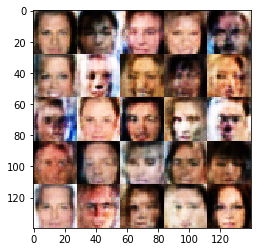

Epoch 1/1... Batch 1310... Discriminator Loss: 1.7427... Generator Loss: 0.2280
Epoch 1/1... Batch 1320... Discriminator Loss: 1.3313... Generator Loss: 0.4350
Epoch 1/1... Batch 1330... Discriminator Loss: 1.6590... Generator Loss: 0.2750
Epoch 1/1... Batch 1340... Discriminator Loss: 1.4258... Generator Loss: 0.4183
Epoch 1/1... Batch 1350... Discriminator Loss: 1.2231... Generator Loss: 0.5435
Epoch 1/1... Batch 1360... Discriminator Loss: 1.6560... Generator Loss: 0.2859
Epoch 1/1... Batch 1370... Discriminator Loss: 1.5943... Generator Loss: 0.2967
Epoch 1/1... Batch 1380... Discriminator Loss: 1.5310... Generator Loss: 0.3423
Epoch 1/1... Batch 1390... Discriminator Loss: 1.2418... Generator Loss: 0.5393
Epoch 1/1... Batch 1400... Discriminator Loss: 1.3885... Generator Loss: 0.4226


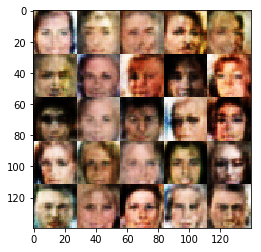

Epoch 1/1... Batch 1410... Discriminator Loss: 1.4093... Generator Loss: 0.4035
Epoch 1/1... Batch 1420... Discriminator Loss: 1.5280... Generator Loss: 0.3279
Epoch 1/1... Batch 1430... Discriminator Loss: 1.0488... Generator Loss: 0.6637
Epoch 1/1... Batch 1440... Discriminator Loss: 1.2083... Generator Loss: 0.5765
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2631... Generator Loss: 0.4971
Epoch 1/1... Batch 1460... Discriminator Loss: 1.3746... Generator Loss: 0.4954
Epoch 1/1... Batch 1470... Discriminator Loss: 1.5364... Generator Loss: 0.3425
Epoch 1/1... Batch 1480... Discriminator Loss: 1.1975... Generator Loss: 0.5740
Epoch 1/1... Batch 1490... Discriminator Loss: 1.3718... Generator Loss: 0.4083
Epoch 1/1... Batch 1500... Discriminator Loss: 1.0291... Generator Loss: 0.7396


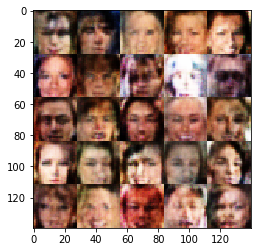

Epoch 1/1... Batch 1510... Discriminator Loss: 1.5303... Generator Loss: 0.3369
Epoch 1/1... Batch 1520... Discriminator Loss: 1.7252... Generator Loss: 0.2789
Epoch 1/1... Batch 1530... Discriminator Loss: 1.2617... Generator Loss: 0.5082
Epoch 1/1... Batch 1540... Discriminator Loss: 1.6819... Generator Loss: 0.2844
Epoch 1/1... Batch 1550... Discriminator Loss: 1.7074... Generator Loss: 0.2647
Epoch 1/1... Batch 1560... Discriminator Loss: 1.6716... Generator Loss: 0.3135
Epoch 1/1... Batch 1570... Discriminator Loss: 2.0145... Generator Loss: 0.1811
Epoch 1/1... Batch 1580... Discriminator Loss: 1.8179... Generator Loss: 0.2562


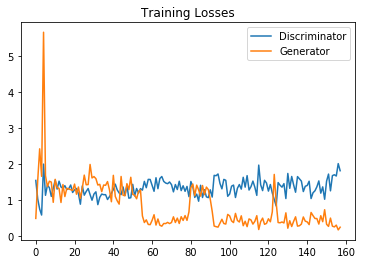

In [41]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.0005

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.